In [1]:
# ! python HW4_PartB_Code_Template/pretrained_models.py

In [1]:
from HW4_PartB_Code_Template.pretrained_models import *
from HW4_PartB_Code_Template.BoxHead import *
from HW4_PartB_Code_Template.utils import *
from HW4_PartB_Code_Template.train import *

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
plt.rcParams["figure.figsize"] =(8,8)

In [3]:
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "./data/hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "./data/hw3_mycocodata_bboxes_comp_zlib.npy"

paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

# Standard Dataloaders Initialization
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 5
print("batch size:", batch_size)

# train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# train_loader = train_build_loader.loader()

test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()


Image  (3265, 3, 300, 400) 
Mask  3265 
Labels  (3265,) 
BBox  (3265,)
batch size: 5


# Plot the proposed boxes from the Pre Trained network

In [ ]:
# Here we keep the top 20, but during training you should keep around 200 boxes from the 1000 proposals
keep_topK=20

with torch.no_grad():
    for iter, batch in enumerate(test_loader, 0):
        images = batch['images'].to(device)

        # Take the features from the backbone
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        # print("For the proposals We have a list containing "+str(len(proposals))+" tensors")
        # print("Each one with shape "+str(proposals[0].shape))
        # print("")
        # print("For the features we have a list of features for each FPN level with shapes")
        # for feat in fpn_feat_list:
        #     print(feat.shape)


        # # Visualization of the proposals
        # for i in range(batch_size):
        #     img_squeeze = transforms.functional.normalize(images[i,:,:,:].to('cpu'),
        #                                                     [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        #                                                     [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
        #     fig,ax=plt.subplots(1,1)
        #     ax.imshow(img_squeeze.permute(1,2,0))


        #     for box in proposals[i]:
        #         box=box.view(-1)
        #         rect=patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color='b')
        #         ax.add_patch(rect)
        #     plt.show()

        break

In [2]:
# Put the path were you save the given pretrained model
pretrained_path='HW4_PartB_Code_Template/checkpoint680.pth'
backbone, rpn = pretrained_models_680(pretrained_path)

# # during training you should keep around 200 boxes 
# keep_topK=200

# with torch.no_grad():
#     batch = next(iter(test_loader))
#     images = batch['images'].to(device)
#     # Take the features from the backbone
#     backout = backbone(images)
#     im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
#     rpnout = rpn(im_lis, backout)
#     proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
#     fpn_feat_list= list(backout.values())
    

In [53]:
faster_rcnn = BoxHead()

In [54]:
labels,regressor_target = faster_rcnn.create_ground_truth(proposals,batch['labels'],batch['bbox'])
labels.shape,regressor_target.shape 

(torch.Size([2000]), torch.Size([2000, 4]))

In [55]:
feature_vectors = faster_rcnn.MultiScaleRoiAlign(fpn_feat_list,proposals)
class_logits, box_pred = faster_rcnn.forward(feature_vectors)
class_logits.shape, box_pred.shape 

(torch.Size([2000, 4]), torch.Size([2000, 12]))

In [166]:
# For some images plot the proposals that are assigned to a no-background class along with their corresponding ground truth box.
indices = torch.where(labels>0)[0] 
image_bounding_boxes_map = torch.div(indices, keep_topK, rounding_mode='trunc')

decoded = output_decoding(regressor_target,proposals)
proposal = torch.vstack(proposals).clone()
decoded[indices].shape 

torch.Size([94, 4])

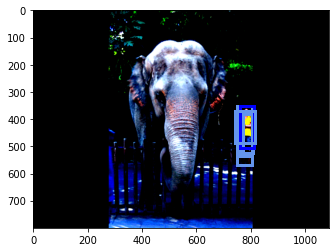

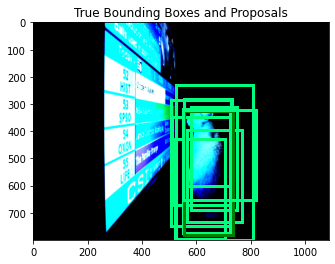

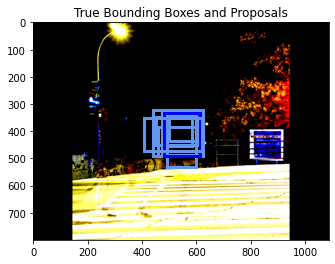

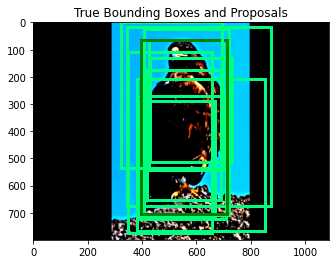

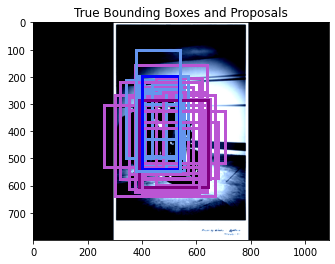

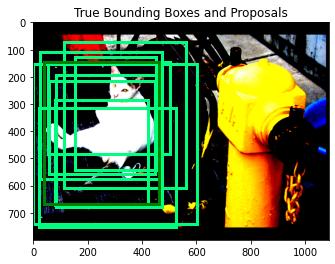

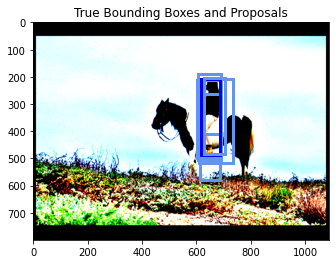

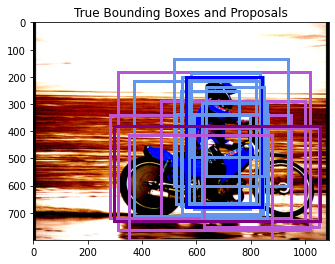

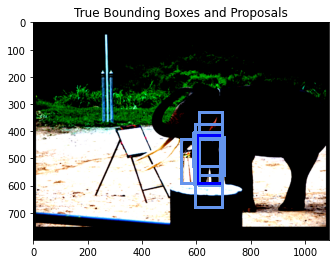

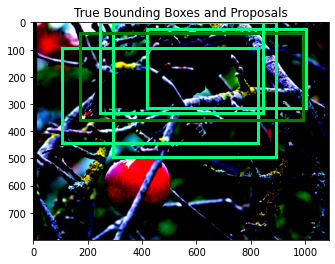

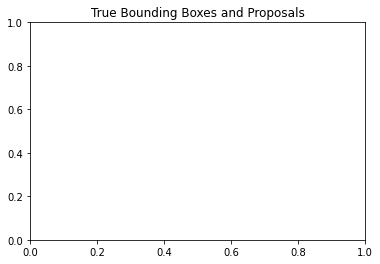

In [224]:
plot_anchors(batch['images'],proposal[indices],decoded[indices],labels[indices],image_bounding_boxes_map)

# Trainer 

In [3]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
model = TrainModel()
model.to(device)

## Setup your training
checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor="val_loss",
                                                   save_top_k=2,
                                                   dirpath='/content/drive/MyDrive/SOLO_data/HW4_PartB_Code_Template/',
                                                   filename='rpn-epoch{epoch:02d}-loss{val_loss:.2f}'
                                                   )
tb_logger = pl_loggers.TensorBoardLogger("/content/drive/MyDrive/SOLO_data/HW4_PartB_Code_Template/log")

In [25]:
# Train your model
trainer = pl.Trainer(gpus=0, max_epochs=15)
trainer.fit(model, train_loader, test_loader)

# Predictions 

In [3]:
model_path = '/Users/smrutichourasia/Desktop/Study/Fall 22/CIS680/HW4/HW4_PartB_Code_Template/fasterrcnn-epochepoch=05-lossval_loss=0.32.ckpt'

In [4]:
model = TrainModel().load_from_checkpoint(model_path)
model.to(device)
model.eval()

TrainModel(
  (faster_rcnn): BoxHead(
    (intermediate_layer): Sequential(
      (0): Linear(in_features=12544, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): ReLU()
    )
    (classifier_layer): Sequential(
      (0): Linear(in_features=1024, out_features=4, bias=True)
    )
    (regressor_layer): Sequential(
      (0): Linear(in_features=1024, out_features=12, bias=True)
    )
    (class_loss): CrossEntropyLoss()
    (regressor_loss): SmoothL1Loss()
  )
)

/Users/smrutichourasia/Desktop/Study/Fall 22/CIS680/HW4/HW4_PartB_Code_Template/utils.py:30: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  pred_area = ((bbox[:,3]-bbox[:,1]) * (bbox[:,2]-bbox[:,0]).T).reshape(-1,1)


Total Class Accuracy		:  92.1
No Background - Class Recall	:  94.44
No Background - Class Precision	:  39.53


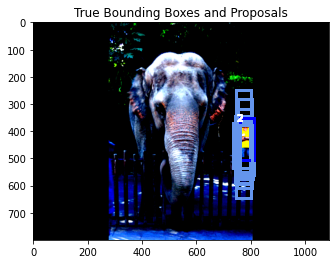

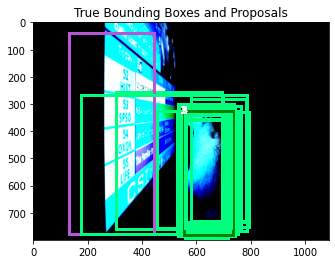

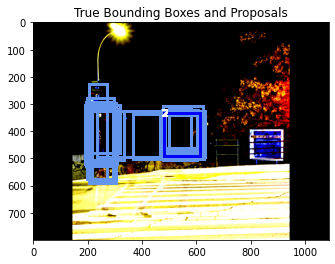

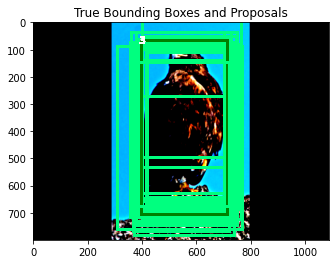

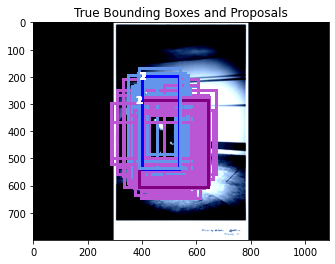

In [6]:
with torch.no_grad():
    batch = next(iter(test_loader))
    images, labels, _, bboxes, _  = batch.values() 
    prediction = model(batch)

    conf_score,pred_labels = torch.max(F.softmax(prediction['class_logits'],dim=1),dim=1)

    indices = torch.where(prediction['labels']>0)
    print("Total Class Accuracy\t\t: ",np.round((torch.where(pred_labels==prediction['labels'],1,0).sum()/len(pred_labels)*100).item(),2))
    print("No Background - Class Recall\t: ",np.round((torch.where(prediction['labels'][indices] == pred_labels[indices],1,0).sum()/len(indices[0])).item()*100,2))
    indices = torch.where(pred_labels>0)
    print("No Background - Class Precision\t: ",np.round((torch.where(prediction['labels'][indices] == pred_labels[indices],1,0).sum()/len(indices[0])).item()*100,2))

    pos_indices = torch.where(pred_labels>0)[0]
    all_indices = (pred_labels[pos_indices].reshape(-1,1)-1)*4
    all_indices = torch.hstack((all_indices,all_indices+1,all_indices+2,all_indices+3))
    box_pred = prediction['box_pred'][pos_indices]
    box_pred = output_decoding(torch.stack([box_pred[i][all_indices[i]] for i in range(len(pos_indices))]),torch.vstack(prediction['proposals'])[pos_indices], device=device)
    gt_box_pred = output_decoding(prediction['regressor_target'][pos_indices],torch.vstack(prediction['proposals'])[pos_indices], device=device)
    
    keep_topK = 200
    image_index = torch.div(pos_indices, keep_topK, rounding_mode='trunc')
    plot_anchors(images,box_pred,gt_box_pred,pred_labels[pos_indices].detach().numpy(),image_index)

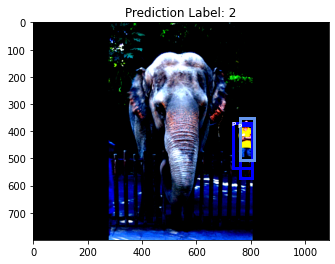

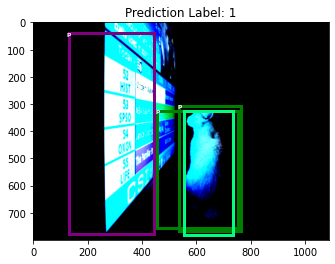

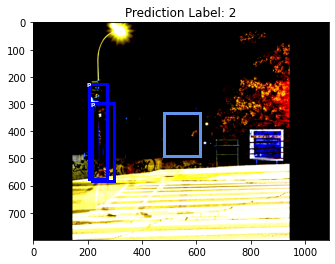

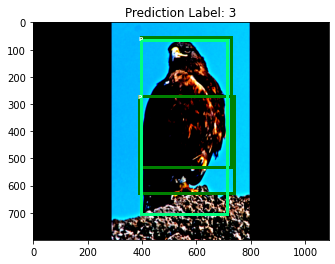

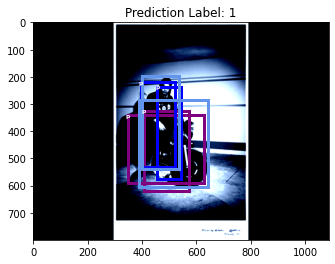

In [8]:
final_pred, final_conf, final_label = model.faster_rcnn.postprocess_detections(prediction, keep_num_postNMS=2)
plot_predictions(images,final_pred,final_label,bboxes)

In [6]:
hold_images_path='data/hold_out_images.npz'
test_images=np.load(hold_images_path,allow_pickle=True)['input_images']

In [ ]:
dict()

In [7]:
for i, numpy_image in enumerate(test_images, 0):
        images = torch.from_numpy(numpy_image).to(device)
        backout = backbone(images)
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        rpnout = rpn(im_lis, backout)
        proposals=[proposal[0:model.keep_topK,:] for proposal in rpnout[0]]
        fpn_feat_list= list(backout.values())
        feature_vectors = model.faster_rcnn.MultiScaleRoiAlign(fpn_feat_list,proposals)
        class_logits, box_pred = model.faster_rcnn.forward(feature_vectors)
        prediction = dict(labels=torch.zeros(len(class_logits)),class_logits=class_logits,regressor_target=box_pred,box_pred=box_pred,proposals=proposals)
        final_pred, final_conf, final_label = model.faster_rcnn.postprocess_detections(prediction, keep_num_postNMS=2)
        break

/Users/smrutichourasia/Desktop/Study/Fall 22/CIS680/HW4/HW4_PartB_Code_Template/utils.py:32: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  pred_area = ((bbox[:,3]-bbox[:,1]) * (bbox[:,2]-bbox[:,0]).T).reshape(-1,1)


In [10]:
final_pred,final_conf,final_label

([tensor([[656.1045, 322.7598, 956.5509, 505.3091],
          [262.2700, 279.3697, 722.4817, 578.6024]], grad_fn=<CatBackward0>)],
 [tensor([1.5553, 1.4564], grad_fn=<CatBackward0>)],
 [tensor([1, 1])])

In [13]:
cpu_boxes = []
cpu_scores = []
cpu_labels = []
for box, score, label in zip(final_pred,final_conf,final_label):
    if box is None:
        cpu_boxes.append(None)
        cpu_scores.append(None)
        cpu_labels.append(None)
    else:
        cpu_boxes.append(box.to('cpu').detach().numpy())
        cpu_scores.append(score.to('cpu').detach().numpy())
        cpu_labels.append(label.to('cpu').detach().numpy())


In [11]:
pred = []
target = []
c_p = []
c_l = []
for idx,batch in enumerate(test_loader):
    print(idx)
    with torch.no_grad():
        images, labels, _, bboxes, _  = batch.values() 
        prediction = model(batch)
        final_pred, final_conf, final_label = model.faster_rcnn.postprocess_detections(prediction,keep_num_preNMS=50, keep_num_postNMS=3)
        pred.extend([dict(boxes=final_pred[i],scores=final_conf[i],labels=final_label[i].to(device)) for i in range(len(final_conf))])
        target.extend([dict(boxes=bboxes[i].to(device),labels=labels[i].to(device)) for i in range(len(final_conf))])
        c_p.extend([prediction['class_logits']])
        c_l.extend(prediction['labels'])

In [43]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric = MeanAveragePrecision()
metric.update(pred, target)
from pprint import pprint
pprint(metric.compute())

from torchmetrics import AveragePrecision
average_precision = AveragePrecision(num_classes=4, average=None)

{'map': tensor(0.1938),
 'map_50': tensor(0.5725),
 'map_75': tensor(0.0709),
 'map_large': tensor(0.1950),
 'map_medium': tensor(0.1000),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.2462),
 'mar_10': tensor(0.4341),
 'mar_100': tensor(0.4341),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.4423),
 'mar_medium': tensor(0.1000),
 'mar_small': tensor(-1.)}


/Users/smrutichourasia/opt/anaconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [50]:
average_precision(torch.vstack(c_p),torch.stack(c_l))

[tensor(0.9983), tensor(0.4867), tensor(0.5043), tensor(0.6117)]